# Data wrangling 

##### By Wessam Alhallak

## Table of Contents
- [Introduction](#intro)
- [The Data](#data)
- [Gathering data](#gather)
- [Assessing data](#assess)
   - [Quality](#quality)
   - [Tidiness](#tidiness)
- [Cleaning data](#clean)
- [Storing](#storing)
- [Analyzing, and Visualizing](#Analysing)
   - [Insight one & visualization](#one)
   - [Insight two](#two)
   - [Insight three & visualization](#three)
   - [Insight four & visualization](#four)

<a id='intro'></a>
## Introduction

wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

<a id="data"></a>
## The Data
### Enhanced Twitter Archive
The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).

### Additional Data via the Twitter API

Back to the basic-ness of Twitter archives: retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But you, because you have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. And guess what? You're going to query Twitter's API to gather this valuable data.


### Image Predictions File
One more cool thing: I ran every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).


In [1]:
#import packages
import pandas as pd
import requests
import os as os
import json 
import matplotlib.pyplot as plt
import tweepy
from timeit import default_timer as timer
import ast
import re
import seaborn as sns

<a id="gather"> </a>
## Gathring Data

### Reading The CSV from local file system

In [2]:
df_csv=pd.read_csv("twitter-archive-enhanced.csv")

### Test

In [76]:
df_csv.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Reading The img  Data file

In [4]:
imgpre_url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

In [5]:
imgpre_filename=imgpre_url.split("/")[-1]

In [6]:
response=requests.get(imgpre_url)

### Saving The img Data File

In [7]:
with open(imgpre_filename,mode="wb") as file:
    file.write(response.content)

In [8]:
df_img=pd.read_csv(imgpre_filename,sep="\t")

### Test

In [9]:
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## Prapring the api creditial from json file ##

In [10]:
#you need to write your api in the attached json file"

if (0):
    credintials=pd.read_json("TweeterApiToken.json")
    credintials.head()

    consumer_key = credintials.tokens.APIkey
    consumer_secret = credintials.tokens.APISecretkey
    access_token = credintials.tokens.AccessToken
    access_secret = credintials.tokens.AccessTokenSecret

    auth=tweepy.OAuthHandler(consumer_key,consumer_secret)
    auth.set_access_token(access_token,access_secret)

    api=tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [11]:
# you need to change 0 to 1 if you want to start reading the tweets 
if (0) :
    start = timer()
    failer={}
    Readinglog=""
    n=0
    with open ("tweet_json.txt",mode="w") as file:
        for tweetid in df_csv.tweet_id:
            n=n+1
            Readinglog+=(str(n)+" "+str(tweetid)+" ")
            print ( n," : ",timer() )
            try:
                temp=api.get_status(tweetid, tweet_mode='extended')._json
                Readinglog+="Success "
                json.dump(temp,file)            
                file.writelines("\n")
            except tweepy.TweepError as e:
                Readinglog+="Faild "
                failer[tweetid]=e
                pass
            #print(temp["favorite"])#favorite
            Readinglog+="\n"
            if n == 10000:
                break
    end = timer()
    print ( end - start)
    
    start = timer()
    failer={}
    Readinglog1=""
    n=0
    with open ("tweet_json1.txt",mode="w") as file:
        for tweetid in df_csv.tweet_id:
            n=n+1
            Readinglog1+=(str(n)+" "+str(tweetid)+" ")
            print ( n," : ",timer() )
            try:
                temp=api.get_status(tweetid, tweet_mode='extended')._json
                Readinglog1+="Success "
                json.dump(temp,file)            
                file.writelines("\n")
            except tweepy.TweepError as e:
                Readinglog1+="Faild "
                failer[tweetid]=e
                pass
            #print(temp["favorite"])#favorite
            Readinglog1+="\n"
            if n == 10:
                break

    end = timer()
    print ( end - start)

In [12]:
#https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html
with open ("tweet_json1.txt",mode="r") as file:
    lines=file.readlines()

In [13]:
json.loads(lines[3])

{'created_at': 'Sun Jul 30 15:58:51 +0000 2017',
 'id': 891689557279858688,
 'id_str': '891689557279858688',
 'full_text': 'This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ',
 'truncated': False,
 'display_text_range': [0, 79],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 891689552724799489,
    'id_str': '891689552724799489',
    'indices': [80, 103],
    'media_url': 'http://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg',
    'url': 'https://t.co/tD36da7qLQ',
    'display_url': 'pic.twitter.com/tD36da7qLQ',
    'expanded_url': 'https://twitter.com/dog_rates/status/891689557279858688/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 510, 'h': 680, 'resize': 'fit'},
     'medium': {'w': 901, 'h': 1200, 'resize': 'fit'},
     'large': {'w': 1201,

In [14]:
with open ("tweet_json.txt",mode="r") as file:
    lines=file.readlines()

In [15]:
df_list=[]
for line in lines:
    line=json.loads(line)
    df_list.append({
        "tweet_id":line["id"],
        "favorite_count":line["favorite_count"],
        "retweet_count":line["retweet_count"],
           })

In [16]:
df_api=pd.DataFrame(df_list)

### Test

In [17]:
df_api.head()

,favorite_count,retweet_count,tweet_id
0,37731,8221,892420643555336193
1,32404,6077,892177421306343426
2,24401,4022,891815181378084864
3,41040,8376,891689557279858688
4,39238,9079,891327558926688256


<a id="assess"></a>
 ## Assessing
 

In [18]:
df_csv.head(50)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [19]:
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [20]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [21]:
df_api.head()

,favorite_count,retweet_count,tweet_id
0,37731,8221,892420643555336193
1,32404,6077,892177421306343426
2,24401,4022,891815181378084864
3,41040,8376,891689557279858688
4,39238,9079,891327558926688256


In [22]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [23]:
df_csv.doggo.unique()

array(['None', 'doggo'], dtype=object)

In [24]:
df_csv.floofer.unique()

array(['None', 'floofer'], dtype=object)

In [25]:
df_csv.puppo.unique()

array(['None', 'puppo'], dtype=object)

In [26]:
df_csv.pupper.unique()

array(['None', 'pupper'], dtype=object)

In [27]:
df_csv[df_csv.expanded_urls.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 30 to 2298
Data columns (total 17 columns):
tweet_id                      59 non-null int64
in_reply_to_status_id         55 non-null float64
in_reply_to_user_id           55 non-null float64
timestamp                     59 non-null object
source                        59 non-null object
text                          59 non-null object
retweeted_status_id           1 non-null float64
retweeted_status_user_id      1 non-null float64
retweeted_status_timestamp    1 non-null object
expanded_urls                 0 non-null object
rating_numerator              59 non-null int64
rating_denominator            59 non-null int64
name                          59 non-null object
doggo                         59 non-null object
floofer                       59 non-null object
pupper                        59 non-null object
puppo                         59 non-null object
dtypes: float64(4), int64(3), object(10)
memory usage: 8.3+ KB


In [28]:
df_csv[df_csv.expanded_urls.isna()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [29]:
df_csv[df_csv.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024352C618D0>,
      dtype=object)

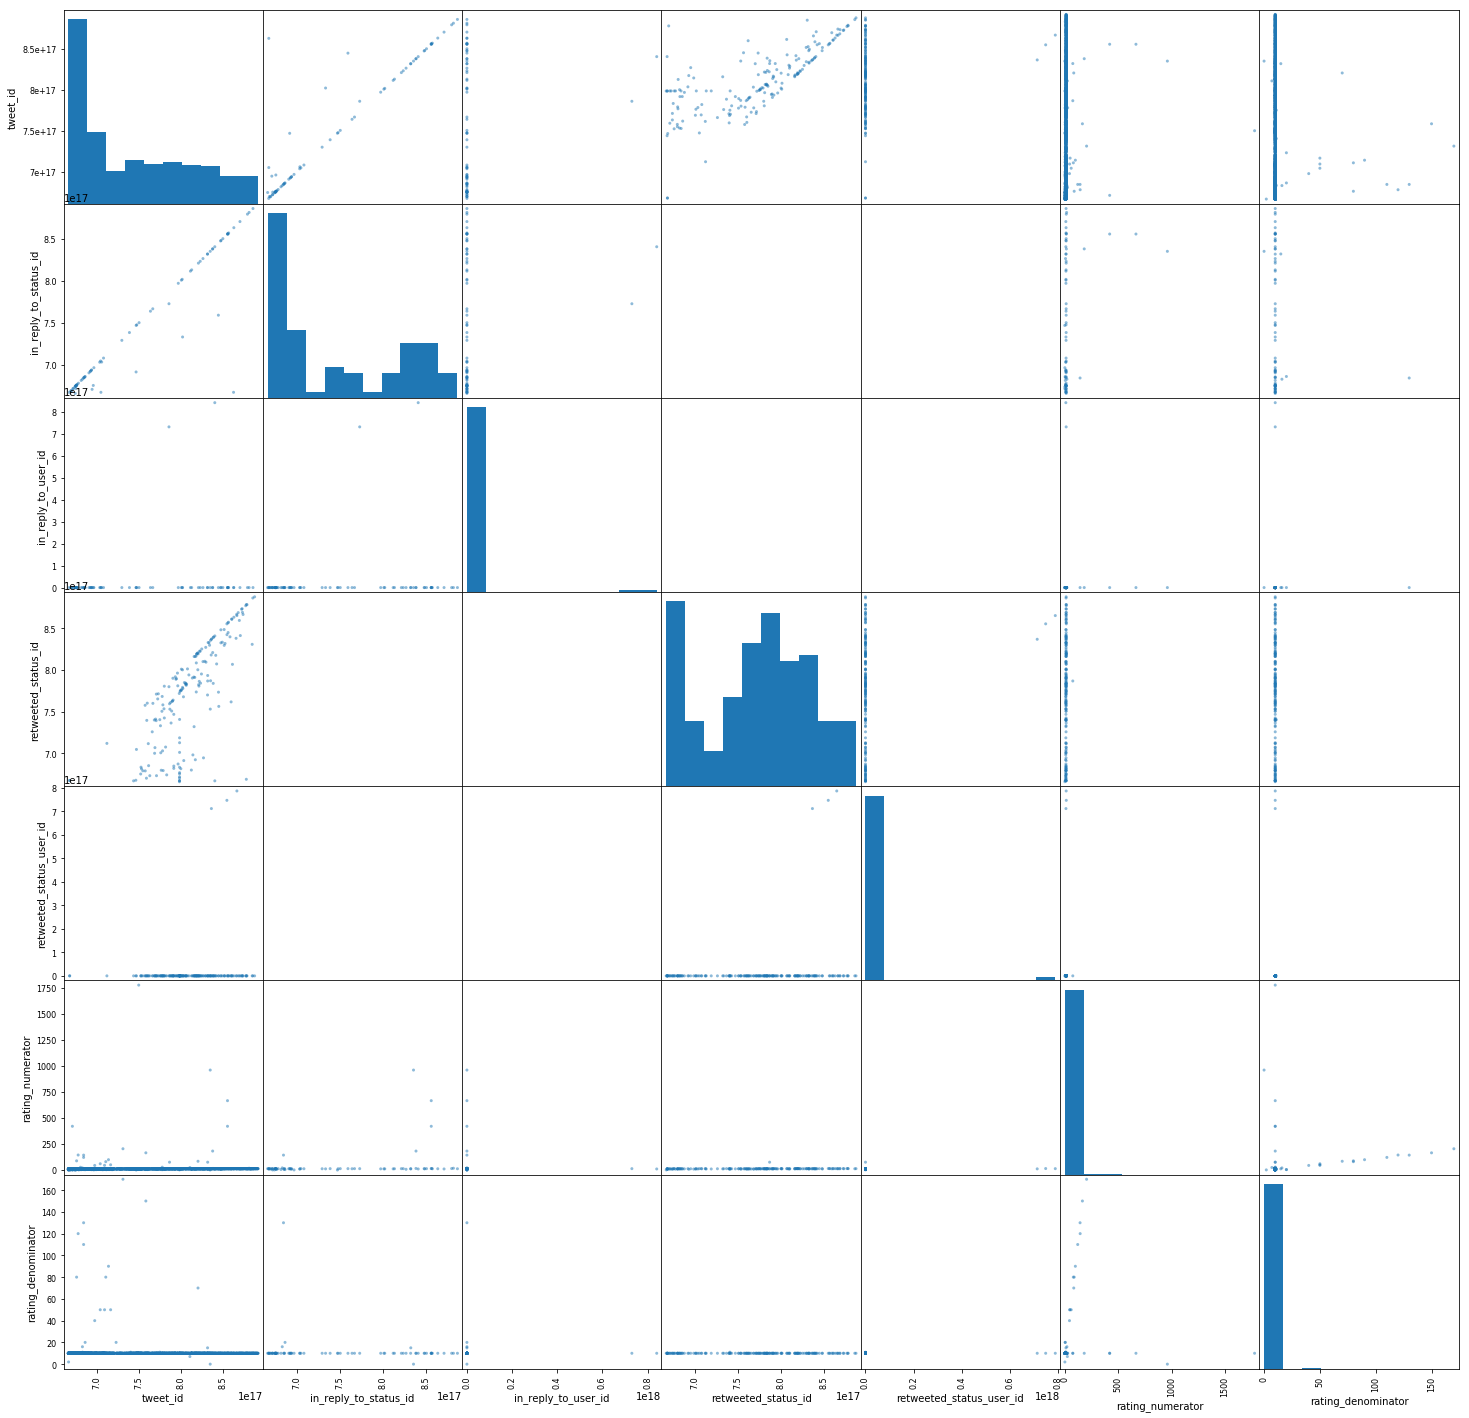

In [30]:
pd.scatter_matrix(df_csv,figsize=(25,25))

In [31]:
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [32]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [33]:
df_img.p3.unique()

array(['Shetland_sheepdog', 'Rhodesian_ridgeback', 'bloodhound',
       'miniature_pinscher', 'Doberman', 'Greater_Swiss_Mountain_dog',
       'terrapin', 'fur_coat', 'golden_retriever',
       'soft-coated_wheaten_terrier', 'Labrador_retriever', 'Pekinese',
       'Ibizan_hound', 'French_bulldog', 'malinois', 'Dandie_Dinmont',
       'borzoi', 'partridge', 'bookcase', 'basenji', 'miniature_poodle',
       'great_grey_owl', 'groenendael', 'Eskimo_dog', 'hamster', 'briard',
       'papillon', 'flat-coated_retriever', 'gar', 'Chihuahua',
       'Shih-Tzu', 'Pomeranian', 'dingo', 'power_drill', 'Saluki',
       'Great_Pyrenees', 'West_Highland_white_terrier', 'collie',
       'toy_poodle', 'vizsla', 'acorn', 'giant_schnauzer', 'teddy',
       'common_iguana', 'wig', 'water_buffalo', 'coyote', 'seat_belt',
       'kelpie', 'space_heater', 'Brabancon_griffon', 'standard_poodle',
       'beagle', 'Irish_water_spaniel', 'bluetick', 'Weimaraner',
       'Chesapeake_Bay_retriever', 'toilet_tiss

In [34]:
df_img.img_num.unique()

array([1, 4, 2, 3], dtype=int64)

In [35]:
df_img[df_img.img_num==4].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 144 to 2040
Data columns (total 12 columns):
tweet_id    31 non-null int64
jpg_url     31 non-null object
img_num     31 non-null int64
p1          31 non-null object
p1_conf     31 non-null float64
p1_dog      31 non-null bool
p2          31 non-null object
p2_conf     31 non-null float64
p2_dog      31 non-null bool
p3          31 non-null object
p3_conf     31 non-null float64
p3_dog      31 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 2.5+ KB


In [36]:
df_img[df_img.img_num==4].head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
144,668623201287675904,https://pbs.twimg.com/media/CUdtP1xUYAIeBnE.jpg,4,Chihuahua,0.708163,True,Pomeranian,0.091372,True,titi,0.067325,False
779,689905486972461056,https://pbs.twimg.com/media/CZMJYCRVAAE35Wk.jpg,4,Pomeranian,0.943331,True,Shetland_sheepdog,0.023675,True,chow,0.007165,True
1024,710588934686908417,https://pbs.twimg.com/media/CdyE2x1W8AAe0TG.jpg,4,Pembroke,0.982004,True,Cardigan,0.008943,True,malamute,0.007550,True
1161,734787690684657664,https://pbs.twimg.com/media/CjJ9gQ1WgAAXQtJ.jpg,4,golden_retriever,0.883991,True,chow,0.023542,True,Labrador_retriever,0.016056,True
1286,750868782890057730,https://pbs.twimg.com/media/CmufLLsXYAAsU0r.jpg,4,toy_poodle,0.912648,True,miniature_poodle,0.035059,True,seat_belt,0.026376,False


In [37]:
 df_api.head()

,favorite_count,retweet_count,tweet_id
0,37731,8221,892420643555336193
1,32404,6077,892177421306343426
2,24401,4022,891815181378084864
3,41040,8376,891689557279858688
4,39238,9079,891327558926688256


In [38]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
favorite_count    2339 non-null int64
retweet_count     2339 non-null int64
tweet_id          2339 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


<a id="quality"></a>

## Assessing Results 

### Quality: 
 
 #### df_csv
 1 - time stamp need to be changed to datatime instead of string<br/>
 2 - dummy varialbs ( dog type ) need to be cleaned into int ( boolean)<br/>
 3 - in_reply_to_status_id should be changed to string type <br/>
 4 - retweeted_status_user_id  should be changed to string type <br/>
 5 - rating_numerator ,rating_denominator  changing into one float variable<br/>
 #### df_img:
 changing id's into string
 #### df_api

 changing id's into string
 

<a id="tidiness"></a>
 

### Tideness
 
1 - Dog stages need to be combined into one column<br/>
2 -  df_api , df_csv  represent the same obeservations it would better to be merged together
 but we should be careful about the nullable and deference count between the raw<br/>
3 - merged , df_img represent the same obeservations it would better to be merged together
 but we should be careful about the nullable and deference count between the raw

<a id="clean"></a>
## Cleaning  Data

### Quality 

### df_csv
First We will copy our dataframe to a new data frame to ensure the consisty of our work

In [39]:
df_csv_clean=df_csv.copy()

#### Define

chaging time into datatime type

#### Code

In [40]:
df_csv_clean["timestamp"]=pd.to_datetime(df_csv_clean.timestamp)

#### Test

In [41]:
df_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

#### Define

chaging tweet_id into string type


#### Code

In [42]:
df_csv_clean["tweet_id"]=df_csv_clean["tweet_id"].astype(str)
#df_csv_clean["retweeted_status_id"]=df_csv_clean["retweeted_status_id"].astype(str)
#df_csv_clean["retweeted_status_user_id"]=df_csv_clean["retweeted_status_user_id"].astype(str)
#df_csv_clean["in_reply_to_status_id"]=df_csv_clean["in_reply_to_status_id"].astype(str)
#df_csv_clean["in_reply_to_user_id"]=df_csv_clean["in_reply_to_user_id"].astype(str)


#### Test

In [43]:
df_csv_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Define 

Drop retweeted_status_id, retweeted_status_user_id,in_reply_to_status_id,in_reply_to_user_id

#### Code

In [44]:
df_csv_clean.drop(["retweeted_status_id",
                    "retweeted_status_user_id",
                    "in_reply_to_status_id",
                    "in_reply_to_user_id",
                   "retweeted_status_timestamp"],
                  axis=1,inplace=True)

#### Test

In [45]:
df_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 221.0+ KB


#### Define
The current pipeline captures incorrect values when rating numerators contain decimals
and it will better to compine both numerator and deomerator in one column as it descripe one mesure


#### Code

In [46]:
df_csv_clean[df_csv_clean.rating_numerator>10].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1455 entries, 0 to 2339
Data columns (total 12 columns):
tweet_id              1455 non-null object
timestamp             1455 non-null datetime64[ns]
source                1455 non-null object
text                  1455 non-null object
expanded_urls         1412 non-null object
rating_numerator      1455 non-null int64
rating_denominator    1455 non-null int64
name                  1455 non-null object
doggo                 1455 non-null object
floofer               1455 non-null object
pupper                1455 non-null object
puppo                 1455 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 147.8+ KB


In [47]:
ratting=df_csv_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
df_csv_clean.rating_numerator=ratting[0].astype(float)
df_csv_clean.rating_denominator=ratting[1].astype(float)
df_csv_clean=df_csv_clean[df_csv_clean["rating_denominator"]!=0]

#### Test 

In [48]:
df_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2355 non-null object
timestamp             2355 non-null datetime64[ns]
source                2355 non-null object
text                  2355 non-null object
expanded_urls         2297 non-null object
rating_numerator      2355 non-null float64
rating_denominator    2355 non-null float64
name                  2355 non-null object
doggo                 2355 non-null object
floofer               2355 non-null object
pupper                2355 non-null object
puppo                 2355 non-null object
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 239.2+ KB


In [49]:
df_csv_clean.describe()

,rating_numerator,rating_denominator
count,2355.000000,2355.000000
mean,12.661584,10.459873
std,41.485316,6.743226
min,0.000000,2.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


### df_img
Copy df_img to a new dataframe


In [50]:
df_img_clean=df_img.copy()

#### Define
1- chaging id into string

#### Code

In [51]:
df_img_clean["tweet_id"]=df_img_clean["tweet_id"].astype(str)

#### Test

In [52]:
df_img_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [53]:
df_img_clean.describe()

,img_num,p1_conf,p2_conf,p3_conf
count,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,1.203855,0.594548,1.345886e-01,6.032417e-02
std,0.561875,0.271174,1.006657e-01,5.090593e-02
min,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,1.000000,0.843855,1.955655e-01,9.180755e-02
max,4.000000,1.000000,4.880140e-01,2.734190e-01


### df_api  ###
Copy df_api into other cleaning Dataframe

In [54]:
df_api_clean=df_api.copy()

#### Define
chage id into string

#### Code

In [55]:
df_api_clean["tweet_id"]=df_api_clean["tweet_id"].astype(str)

#### Test

In [56]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
favorite_count    2339 non-null int64
retweet_count     2339 non-null int64
tweet_id          2339 non-null object
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


In [57]:
df_api.describe()

,favorite_count,retweet_count,tweet_id
count,2339.000000,2339.000000,2.339000e+03
mean,7887.823001,2899.079949,7.421620e+17
std,12224.011478,4888.510848,6.828729e+16
min,0.000000,0.000000,6.660209e+17
25%,1366.500000,583.000000,6.783378e+17
50%,3431.000000,1353.000000,7.186133e+17
75%,9658.500000,3379.000000,7.986907e+17
max,162830.000000,82862.000000,8.924206e+17


## Cleaning
### Tidiness

#### df_csv_clean 
#### Define

Dog stages need to be combined into one column

In [58]:
df_csv_clean.loc[(df_csv_clean[['doggo', 'floofer', 'pupper', 'puppo']] != 'None'
                 ).sum(axis=1) > 1]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,2017-04-22 18:31:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13.0,10.0,None,doggo,None,None,puppo
200,854010172552949760,2017-04-17 16:34:26,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11.0,10.0,None,doggo,floofer,None,None
460,817777686764523521,2017-01-07 16:59:28,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13.0,10.0,Dido,doggo,None,pupper,None
531,808106460588765185,2016-12-12 00:29:28,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12.0,10.0,None,doggo,None,pupper,None
565,802265048156610565,2016-11-25 21:37:47,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",https://twitter.com/dog_rates/status/802265048...,11.0,10.0,None,doggo,None,pupper,None
575,801115127852503040,2016-11-22 17:28:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12.0,10.0,Bones,doggo,None,pupper,None
705,785639753186217984,2016-10-11 00:34:48,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10.0,10.0,Pinot,doggo,None,pupper,None
733,781308096455073793,2016-09-29 01:42:20,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",https://vine.co/v/5rgu2Law2ut,12.0,10.0,None,doggo,None,pupper,None
778,775898661951791106,2016-09-14 03:27:11,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",https://twitter.com/dog_rates/status/733109485...,12.0,10.0,None,doggo,None,pupper,None
822,770093767776997377,2016-08-29 03:00:36,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,https://twitter.com/dog_rates/status/741067306...,12.0,10.0,just,doggo,None,pupper,None


#### Code

In [59]:
df_csv_clean.doggo.replace("None","",inplace=True)
df_csv_clean.floofer.replace("None","",inplace=True)
df_csv_clean.pupper.replace("None","",inplace=True)
df_csv_clean.puppo.replace("None","",inplace=True)

In [60]:
df_csv_clean['stage'] = df_csv_clean.doggo + df_csv_clean.floofer + df_csv_clean.pupper + df_csv_clean.puppo
df_csv_clean.loc[df_csv_clean.stage == 'doggopupper', 'stage'] = 'doggo,pupper'
df_csv_clean.loc[df_csv_clean.stage == 'doggopuppo', 'stage'] = 'doggo,puppo'
df_csv_clean.loc[df_csv_clean.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'
df_csv_clean.stage.replace("","None",inplace=True)

#### Test

In [61]:
df_csv_clean.stage.value_counts()

None             1975
pupper            245
doggo              83
puppo              29
doggo,pupper       12
floofer             9
doggo,floofer       1
doggo,puppo         1
Name: stage, dtype: int64

#### Define
Drop the dummy variabls

#### Code

In [62]:
df_csv_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'],axis=1,inplace=True)

#### Test

In [63]:
df_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2355 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2355 non-null object
timestamp             2355 non-null datetime64[ns]
source                2355 non-null object
text                  2355 non-null object
expanded_urls         2297 non-null object
rating_numerator      2355 non-null float64
rating_denominator    2355 non-null float64
name                  2355 non-null object
stage                 2355 non-null object
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 184.0+ KB


 ### df_api ,  df_csv 
 #### Define ##
 
represent the same obeservations it would better to be merged together but we should be careful about the nullable and deference count between the raw


#### Code
We will Use merge for two Dataframe

In [64]:
merged_1=df_csv_clean.merge(df_api_clean,how="inner",on="tweet_id")

#### Test

In [65]:
merged_1.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,37731,8221
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,32404,6077
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,24401,4022
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,41040,8376
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,39238,9079


In [66]:
merged_1.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count
count,2338.000000,2338.000000,2338.000000,2338.000000
mean,12.663828,10.462789,7890.263045,2900.286997
std,41.635748,6.767591,12226.056769,4889.207987
min,0.000000,2.000000,0.000000,0.000000
25%,10.000000,10.000000,1365.250000,583.500000
50%,11.000000,10.000000,3436.500000,1356.500000
75%,12.000000,10.000000,9658.750000,3379.500000
max,1776.000000,170.000000,162830.000000,82862.000000


In [67]:
merged_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2338 entries, 0 to 2337
Data columns (total 11 columns):
tweet_id              2338 non-null object
timestamp             2338 non-null datetime64[ns]
source                2338 non-null object
text                  2338 non-null object
expanded_urls         2280 non-null object
rating_numerator      2338 non-null float64
rating_denominator    2338 non-null float64
name                  2338 non-null object
stage                 2338 non-null object
favorite_count        2338 non-null int64
retweet_count         2338 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 219.2+ KB


### df_img ,  merged_1
#### Define
df_img represent the same obeservations it would better to be merged together
 but we should be careful about the nullable and deference count between the raw

#### Code

In [68]:
merged_2=merged_1.merge(df_img_clean,how="inner",on="tweet_id")

#### Test 

In [69]:
merged_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 22 columns):
tweet_id              2066 non-null object
timestamp             2066 non-null datetime64[ns]
source                2066 non-null object
text                  2066 non-null object
expanded_urls         2066 non-null object
rating_numerator      2066 non-null float64
rating_denominator    2066 non-null float64
name                  2066 non-null object
stage                 2066 non-null object
favorite_count        2066 non-null int64
retweet_count         2066 non-null int64
jpg_url               2066 non-null object
img_num               2066 non-null int64
p1                    2066 non-null object
p1_conf               2066 non-null float64
p1_dog                2066 non-null bool
p2                    2066 non-null object
p2_conf               2066 non-null float64
p2_dog                2066 non-null bool
p3                    2066 non-null object
p3_conf               2066 n

In [70]:
merged_2.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,2066.000000,2066.000000,2066.000000,2066.000000,2066.000000,2066.000000,2.066000e+03,2.066000e+03
mean,12.221578,10.513553,8332.854792,2772.818490,1.203291,0.594568,1.346716e-01,6.034151e-02
std,40.742699,7.192615,12562.080796,4830.478374,0.562172,0.271062,1.007233e-01,5.094272e-02
min,0.000000,2.000000,0.000000,11.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,1584.500000,591.000000,1.000000,0.364254,5.387868e-02,1.621080e-02
50%,11.000000,10.000000,3664.500000,1305.000000,1.000000,0.588030,1.184015e-01,4.939645e-02
75%,12.000000,10.000000,10408.500000,3199.500000,1.000000,0.843883,1.955693e-01,9.208967e-02
max,1776.000000,170.000000,162830.000000,82862.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [71]:
merged_2.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,favorite_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,37731,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,32404,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,24401,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,41040,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,39238,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [73]:
df=merged_2.copy()

<a id="storing"></a>
## Saving Data 
### saving as csv  in local file system

In [74]:
df.to_csv("twitter_archive_master.csv",index_label="tweetid")

<a id="analysing"></a>
## Analysing and Visulisation
### Brief insights

Using the  factors ( Catagories ) Stage , and name

In [79]:
df.groupby("stage").mean()

,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p1_dog,p2_conf,p2_dog,p3_conf,p3_dog
stage,,,,,,,,,,,
None,12.427799,10.608023,7913.383954,2562.620630,1.191404,0.591132,0.738682,0.134372,0.746132,0.061148,0.722636
doggo,11.970149,10.000000,18727.641791,7708.029851,1.313433,0.581910,0.761194,0.159575,0.776119,0.060745,0.701493
"doggo,floofer",11.000000,10.000000,16429.000000,3237.000000,1.000000,0.354733,1.000000,0.177538,1.000000,0.131706,1.000000
"doggo,pupper",11.181818,10.000000,10563.636364,5149.909091,1.090909,0.844620,0.909091,0.076483,0.818182,0.026425,0.636364
"doggo,puppo",13.000000,10.000000,45876.000000,18117.000000,1.000000,0.321676,1.000000,0.115138,1.000000,0.096100,1.000000
floofer,12.000000,10.000000,12563.000000,4638.428571,1.142857,0.609204,1.000000,0.155319,1.000000,0.047997,0.857143
pupper,10.683744,10.000000,6683.094787,2312.976303,1.251185,0.602090,0.701422,0.130868,0.725118,0.057050,0.696682
puppo,12.000000,10.000000,20673.565217,6170.521739,1.434783,0.721344,0.826087,0.140264,0.913043,0.043497,0.956522


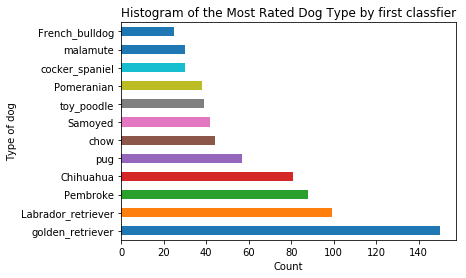

In [105]:
df_p1 = df.groupby('p1').filter(lambda x: len(x) >= 25)

df_p1['p1'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the Most Rated Dog Type by first classfier')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output1.png',bbox_inches='tight');

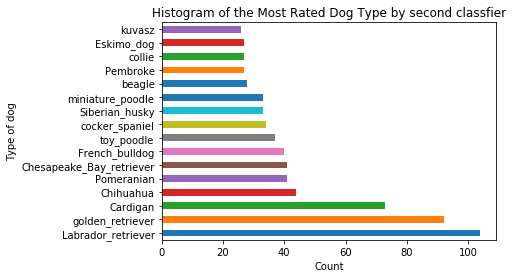

In [106]:
df_p2 = df.groupby('p2').filter(lambda x: len(x) >= 25)

df_p2['p2'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the Most Rated Dog Type by second classfier')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output2.png',bbox_inches='tight');

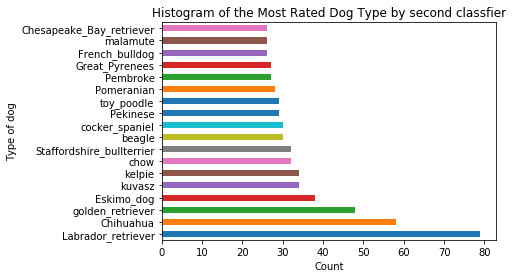

In [107]:
df_p3 = df.groupby('p3').filter(lambda x: len(x) >= 25)

df_p3['p3'].value_counts().plot(kind = 'barh')
plt.title('Histogram of the Most Rated Dog Type by second classfier')
plt.xlabel('Count')
plt.ylabel('Type of dog')

fig = plt.gcf() 
fig.savefig('output3.png',bbox_inches='tight');

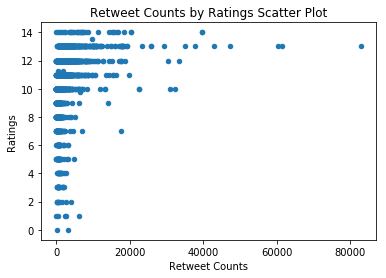

In [113]:
df[df.rating_numerator<15].plot(x='retweet_count', y='rating_numerator', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Retweet Counts by Ratings Scatter Plot')

fig = plt.gcf()
fig.savefig('output4.png',bbox_inches='tight');